In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Input
from keras.initializers import glorot_uniform
import keras.backend as K

%matplotlib inline

mcycle = pd.read_csv('mcycle',delimiter='\t')

Using TensorFlow backend.


In [2]:
mcycle.times = (mcycle.times - mcycle.times.mean())/mcycle.times.std()
mcycle.accel = (mcycle.accel - mcycle.accel.mean())/mcycle.accel.std()

In [3]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [4]:
def mcycleModel(qs=[0.1, 0.5, 0.9]):
    ipt_layer = Input((1,))
    layer1 = Dense(10, activation='relu', kernel_initializer=glorot_uniform())(ipt_layer)
    layer2 = Dense(10, activation='relu', kernel_initializer=glorot_uniform())(layer1)
    
    out1 = Dense(1, name='out1')(layer2)
    out2 = Dense(1, name='out2')(layer2)
    out3 = Dense(1, name='out3')(layer2)
    
    q1, q2, q3 = qs
    model = Model(inputs=ipt_layer, outputs=[out1, out2, out3])
    model.compile(loss={'out1': lambda y,f: tilted_loss(q1,y,f),
                        'out2': lambda y,f: tilted_loss(q2,y,f),
                        'out3': lambda y,f: tilted_loss(q3,y,f),}, 
                  loss_weights={'out1': 1, 'out2': 1, 'out3': 1},
                 optimizer='adadelta')
    
    return model

In [5]:
model = mcycleModel()
x = mcycle.times.values
y = mcycle.accel.values
model.fit(x=x, y=[y, y, y], epochs=2000, batch_size=32, verbose=0)

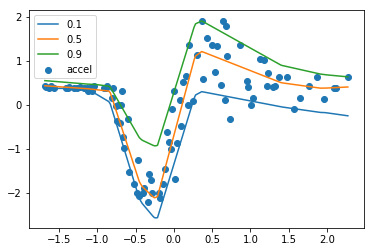

In [6]:
t_test = np.linspace(mcycle.times.min(),mcycle.times.max(),200)
y_test = model.predict(t_test)
plt.scatter(mcycle.times,mcycle.accel)
plt.plot(t_test, y_test[0], label='0.1')
plt.plot(t_test, y_test[1], label='0.5')
plt.plot(t_test, y_test[2], label='0.9')
plt.legend()
plt.show()